## Korea President별 인용구 분석

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Twitter
import lightgbm as lgb
import requests
import pandas as pd 
from bs4 import BeautifulSoup
import glob

In [22]:
def data_setting():
    ys = pd.read_csv("1. 김영삼 대통령 재임기간 인용문 추출.csv", encoding="cp949")
    dj = pd.read_csv("2. 김대중 대통령 재임기간 인용문 추출.csv", encoding="cp949")
    no = pd.read_csv("3. 노무현 대통령 재임기간 인용문 추출.csv", encoding="cp949")
    mb = pd.read_csv("4. 이명박 대통령 재임기간 인용문 추출.csv", encoding="cp949")
    
    ys['category'] = 1
    dj['category'] = 2
    no['category'] = 3
    mb['category'] = 4
    
    total = pd.concat([ys, dj, no, mb]).reset_index(drop=True)
    
    total = total.dropna()
    
    def remove(word):
        word = re.sub("\n", " ", word)
        return word

    total['인용구'] = total['인용구'].apply(remove)
    
    return total

total = data_setting()

In [23]:
total.tail()

,날짜,언론사,뉴스ID,인용구,정보원,category
49448,2008-02-01,세계일보,1.1007e+06,화합 속에 변화를 추구하고 선진화를 바탕으로 새 발전 체제를 열겠다,이명박 대통령,4
49449,2008-02-01,경향신문,1.1001e+06,미국의 루스벨트 대통령도 댐을 짓고 해서 경기를 부양한 예가 있어 그런 점에서 (대...,이명박 대통령,4
49450,2008-02-01,한겨레,1.101e+06,일주일 내내 청와대에 있으려고 생각하지 않는다,이명박 대통령,4
49451,2008-02-01,한국일보,1.1011e+06,저는 (취임 이후) 일주일 내내 청와대에 있으려고 생각하지 않는다 금요일 오후 되면...,이명박 대통령,4
49452,2008-02-01,한겨레,1.101e+06,비영어권 나라에서는 영어를 잘 쓰는 나라들이 못 쓰는 나라보다 훨씬 잘 산다 인수위...,이명박 대통령,4


### 1. 분석

In [24]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [45]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,3))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(total['인용구'], total['category'], \
                                                    test_size=0.4, random_state=0)

len(X_train),len(X_test),len(y_train),len(y_test)

(29604, 19736, 29604, 19736)

In [47]:
def Korea_President():
    model  = clf.fit(X_train, y_train)
    
    y_pred  = model.predict(X_train)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train, y_pred), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train, y_pred), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train, y_pred), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_t = model.predict(X_test)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test, y_pred_t), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test, y_pred_t), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test, y_pred_t), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred_t)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[ 2289     2     3     4]
 [    1  5165     2    10]
 [    3     1  8642    10]
 [    2     1    13 13456]] 


Train classification_report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00      2298
          2       1.00      1.00      1.00      5178
          3       1.00      1.00      1.00      8656
          4       1.00      1.00      1.00     13472

avg / total       1.00      1.00      1.00     29604
 


Train accuracy_score 

1.0 




Test 

Test confusion_matrix 

[[ 969  216  180  156]
 [  55 2658  391  361]
 [  22  242 4848  598]
 [  32  164  524 8320]] 


Test classification_report 

             precision    recall  f1-score   support

          1       0.90      0.64      0.75      1521
          2       0.81      0.77      0.79      3465
          3       0.82      0.85      0.83      5710
          4       0.88      0.92      0.90      9040

avg / total       0.85      0.85      0.85    

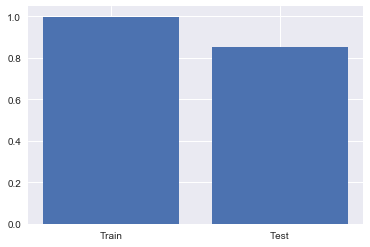

In [48]:
Korea_President()

---